## Imports

In [19]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import json
import cv2
from tqdm import tqdm

## Define Directories

In [16]:
video_dir = r'C:\Users\roshe\Documents\PROJECTS\Sign Language\Dataset\videos'
class_list_file = r'C:\Users\roshe\Documents\PROJECTS\Sign Language\Dataset\wlasl_class_list.txt'
wlasl_json_file = r'C:\Users\roshe\Documents\PROJECTS\Sign Language\Dataset\WLASL_v0.3.json'
json_files = [r'C:\Users\roshe\Documents\PROJECTS\Sign Language\Dataset\nslt_100.json',
              r'C:\Users\roshe\Documents\PROJECTS\Sign Language\Dataset\nslt_300.json',
              r'C:\Users\roshe\Documents\PROJECTS\Sign Language\Dataset\nslt_1000.json',
              r'C:\Users\roshe\Documents\PROJECTS\Sign Language\Dataset\nslt_2000.json']  # Add all JSONs here

output_dir = r'C:\Users\roshe\Documents\PROJECTS\Sign Language\Dataset\Preprocessed_Data'
train_dir = r'C:\Users\roshe\Documents\PROJECTS\Sign Language\Dataset\Final\train'
val_dir = r'C:\Users\roshe\Documents\PROJECTS\Sign Language\Dataset\Final\val'
test_dir = r'C:\Users\roshe\Documents\PROJECTS\Sign Language\Dataset\Final\test'


## Read Directories

In [17]:
# Create output directories if they don't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

class_dict = {}
with open(class_list_file, 'r') as f:
    for line in f.readlines():
        index, gloss = line.strip().split('\t')
        class_dict[int(index)] = gloss.lower()

# Load WLASL_v0.3 JSON file
with open(wlasl_json_file, 'r') as f:
    wlasl_data = json.load(f)

# Load the additional JSON files (nslt_100, nslt_300, etc.)
additional_data = {}
for json_file in json_files:
    with open(json_file, 'r') as f:
        additional_data.update(json.load(f))

### Extract Frames


In [13]:
# Function to extract frames from videos
def extract_frames(video_path, output_folder, fps=25):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error opening video: {video_path}")
        return False

    count = 0
    success = True
    while success:
        success, frame = cap.read()
        if not success:
            break

        frame_id = int(cap.get(cv2.CAP_PROP_POS_FRAMES))
        if frame_id % fps == 0:  # Save every second frame based on FPS
            try:
                cv2.imwrite(os.path.join(output_folder, f'frame_{count:04d}.jpg'), frame)
                count += 1
            except Exception as e:
                print(f"Error saving frame {count} from {video_path}: {e}")

    cap.release()
    return True

## Processing Loop

In [20]:
# Preprocessing loop
missing_video_count = 0
corrupt_video_count = 0
for video_info in tqdm(wlasl_data):
    gloss = video_info['gloss'].lower()  # Normalize case

    # Find the index of the gloss in the class_dict values
    gloss_index = None
    for index, class_gloss in class_dict.items():
        if class_gloss == gloss:
            gloss_index = index
            break

    if gloss_index is None:
        print(f"Warning: Class '{gloss}' not found in class list! Skipping...")
        continue

    for instance in video_info['instances']:
        video_id = instance['video_id']

        if video_id in additional_data:
            subset = additional_data[video_id]['subset']
            if subset not in ['train', 'val']:
                continue

        video_filename = os.path.join(video_dir, f'{video_id}.mp4')
        if not os.path.exists(video_filename):
            missing_video_count += 1
            continue

        label_folder = os.path.join(output_dir, str(gloss_index))
        os.makedirs(label_folder, exist_ok=True)
        instance_folder = os.path.join(label_folder, video_id)
        os.makedirs(instance_folder, exist_ok=True)

        if not extract_frames(video_filename, instance_folder, fps=instance.get('fps', 25)):
            corrupt_video_count +=1
            continue # Skip if video can't be opened or frames can't be extracted

print("Preprocessing complete!")
print(f"Number of missing videos: {missing_video_count}")
print(f"Number of corrupt videos: {corrupt_video_count}")

  8%|▊         | 163/2000 [02:51<27:59,  1.09it/s]

100%|██████████| 2000/2000 [21:03<00:00,  1.58it/s]

Preprocessing complete!
Number of missing videos: 7633
Number of corrupt videos: 0


## Organizing 


In [21]:
import os
import shutil
from tqdm import tqdm

def get_class_mapping(class_list_path):
    class_mapping = {}
    with open(class_list_path, 'r') as file:
        for line in file:
            parts = line.strip().split(maxsplit=1)
            if len(parts) == 2:
                index, class_name = parts
                class_mapping[int(index)] = class_name
    return class_mapping

def transfer_frames(data_dir, final_dir, class_mapping):
    # Ensure the final directory exists
    os.makedirs(final_dir, exist_ok=True)

    for class_index in tqdm(os.listdir(data_dir)):
        class_path = os.path.join(data_dir, class_index)

        if not os.path.isdir(class_path):
            continue

        # Retrieve class name from the mapping
        class_name = class_mapping.get(int(class_index))
        if class_name is None:
            continue

        # Create directory for each class inside the final directory
        class_final_dir = os.path.join(final_dir, class_name)
        os.makedirs(class_final_dir, exist_ok=True)

        # Loop through all video folders in the class folder
        for video_folder in os.listdir(class_path):
            video_path = os.path.join(class_path, video_folder)
            
            if not os.path.isdir(video_path):
                continue

            # Copy each image to the final class directory
            for image in os.listdir(video_path):
                image_path = os.path.join(video_path, image)
                if os.path.isfile(image_path):
                    # Define the target path with a unique name to avoid overwriting
                    new_image_name = f"{video_folder}_{image}"
                    target_path = os.path.join(class_final_dir, new_image_name)
                    shutil.copy(image_path, target_path)

# Example usage
data_directory = r"C:\Users\roshe\Documents\PROJECTS\Sign Language\Dataset\Preprocessed_Data"
final_directory = r"C:\Users\roshe\Documents\PROJECTS\Sign Language\Dataset\Final_2"
class_list_path = r"C:\Users\roshe\Documents\PROJECTS\Sign Language\Dataset\wlasl_class_list.txt"

class_mapping = get_class_mapping(class_list_path)
transfer_frames(data_directory, final_directory, class_mapping)


100%|██████████| 1999/1999 [03:39<00:00,  9.12it/s]


## Normalizing 1

In [22]:
import cv2
import mediapipe as mp
import os
import shutil
import hashlib

# Initialize Mediapipe Hands
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(min_detection_confidence=0.5, min_tracking_confidence=0.5)

# Paths for input and output directories
grayscale_dir = r'C:\Users\roshe\Documents\PROJECTS\Sign Language\Dataset\Final_2'
hand_detected_dir = r'C:\Users\roshe\Documents\PROJECTS\Sign Language\Dataset\Hand_Detected'

# Create output directory if it doesn't exist
if not os.path.exists(hand_detected_dir):
    os.makedirs(hand_detected_dir)

# Process each folder in the grayscale directory
for folder_name in os.listdir(grayscale_dir):
    folder_path = os.path.join(grayscale_dir, folder_name)
    if os.path.isdir(folder_path):
        # Create a corresponding folder in the output directory
        output_folder = os.path.join(hand_detected_dir, folder_name)
        os.makedirs(output_folder, exist_ok=True)

        has_landmarks = False  # Track if any image in this folder has landmarks
        hashes = set()  # Store image hashes to check for duplicates

        # Process each image file in the folder
        for image_file in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image_file)
            image_name = os.path.splitext(image_file)[0]  # Get file name without extension

            # Load the grayscale image
            gray_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            if gray_image is None:
                print(f"Could not read image {image_path}")
                continue

            # Resize image to 255x255
            resized_image = cv2.resize(gray_image, (255, 255))

            # Enhance brightness and contrast for better detection
            alpha = 1.5  # Contrast control (1.0-3.0)
            beta = 50    # Brightness control (0-100)
            enhanced_image = cv2.convertScaleAbs(resized_image, alpha=alpha, beta=beta)

            # Convert grayscale to BGR for Mediapipe processing
            enhanced_bgr = cv2.cvtColor(enhanced_image, cv2.COLOR_GRAY2BGR)

            # Perform hand landmarks detection
            results = hands.process(cv2.cvtColor(enhanced_bgr, cv2.COLOR_BGR2RGB))
            if results.multi_hand_landmarks:
                has_landmarks = True  # At least one frame with landmarks in this folder
                for hand_landmarks in results.multi_hand_landmarks:
                    # Draw hand landmarks with red connections
                    mp.solutions.drawing_utils.draw_landmarks(
                        enhanced_bgr,
                        hand_landmarks,
                        mp_hands.HAND_CONNECTIONS,
                        landmark_drawing_spec=mp.solutions.drawing_utils.DrawingSpec(color=(0, 255, 0), thickness=2, circle_radius=2),
                        connection_drawing_spec=mp.solutions.drawing_utils.DrawingSpec(color=(0, 0, 255), thickness=2)
                    )
                print(f"Hand landmarks detected in {image_file}")
            else:
                print(f"No hand landmarks detected in {image_file}")

            # Save the processed image with hand landmarks
            output_path = os.path.join(output_folder, f"{image_name}.jpg")
            cv2.imwrite(output_path, enhanced_bgr)
            print(f"Saved hand-detected image to {output_path}")

            # Check and delete duplicates
            with open(output_path, 'rb') as f:
                file_hash = hashlib.md5(f.read()).hexdigest()
            if file_hash in hashes:
                os.remove(output_path)
                print(f"Duplicate found and removed: {output_path}")
            else:
                hashes.add(file_hash)

        # Delete folder if no frames with landmarks were detected
        if not has_landmarks:
            print(f"No landmarks detected in any frames for folder {folder_name}. Deleting folder...")
            shutil.rmtree(output_folder)

# Cleanup Mediapipe resources
hands.close()
print("Hand detection, normalization, and duplicate removal complete.")


No hand landmarks detected in 01610_frame_0000.jpg
Saved hand-detected image to C:\Users\roshe\Documents\PROJECTS\Sign Language\Dataset\Hand_Detected\a\01610_frame_0000.jpg
No hand landmarks detected in 01610_frame_0001.jpg
Saved hand-detected image to C:\Users\roshe\Documents\PROJECTS\Sign Language\Dataset\Hand_Detected\a\01610_frame_0001.jpg
No hand landmarks detected in 01610_frame_0002.jpg
Saved hand-detected image to C:\Users\roshe\Documents\PROJECTS\Sign Language\Dataset\Hand_Detected\a\01610_frame_0002.jpg
No hand landmarks detected in 01610_frame_0003.jpg
Saved hand-detected image to C:\Users\roshe\Documents\PROJECTS\Sign Language\Dataset\Hand_Detected\a\01610_frame_0003.jpg
No hand landmarks detected in 01610_frame_0004.jpg
Saved hand-detected image to C:\Users\roshe\Documents\PROJECTS\Sign Language\Dataset\Hand_Detected\a\01610_frame_0004.jpg
No hand landmarks detected in 01612_frame_0000.jpg
Saved hand-detected image to C:\Users\roshe\Documents\PROJECTS\Sign Language\Dataset

c:\Users\roshe\AppData\Local\Programs\Python\Python39\lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


Hand landmarks detected in 01615_frame_0001.jpg
Saved hand-detected image to C:\Users\roshe\Documents\PROJECTS\Sign Language\Dataset\Hand_Detected\a\01615_frame_0001.jpg
No hand landmarks detected in 01615_frame_0002.jpg
Saved hand-detected image to C:\Users\roshe\Documents\PROJECTS\Sign Language\Dataset\Hand_Detected\a\01615_frame_0002.jpg
Hand landmarks detected in 02124_frame_0000.jpg
Saved hand-detected image to C:\Users\roshe\Documents\PROJECTS\Sign Language\Dataset\Hand_Detected\a lot\02124_frame_0000.jpg
Hand landmarks detected in 02124_frame_0001.jpg
Saved hand-detected image to C:\Users\roshe\Documents\PROJECTS\Sign Language\Dataset\Hand_Detected\a lot\02124_frame_0001.jpg
Hand landmarks detected in 02125_frame_0000.jpg
Saved hand-detected image to C:\Users\roshe\Documents\PROJECTS\Sign Language\Dataset\Hand_Detected\a lot\02125_frame_0000.jpg
No hand landmarks detected in 02126_frame_0000.jpg
Saved hand-detected image to C:\Users\roshe\Documents\PROJECTS\Sign Language\Dataset

## Data Generator

In [23]:
import tensorflow as tf
import os
import cv2
import numpy as np

# Directory paths
hand_detected_dir = r'C:\Users\roshe\Documents\PROJECTS\Sign Language\Dataset\Hand_Detected'
image_size = (255, 255)

# Label mapping dictionary
label_mapping = {folder_name: idx for idx, folder_name in enumerate(os.listdir(hand_detected_dir))}

# Define data generator function
def data_generator(batch_size):
    data, labels = [], []
    while True:
        for folder_name in os.listdir(hand_detected_dir):
            folder_path = os.path.join(hand_detected_dir, folder_name)
            label = label_mapping[folder_name]
            if os.path.isdir(folder_path):
                for image_file in os.listdir(folder_path):
                    image_path = os.path.join(folder_path, image_file)
                    image = cv2.imread(image_path)
                    if image is not None:
                        # Resize, normalize, and augment
                        image = cv2.resize(image, image_size) / 255.0
                        data.append(image)
                        labels.append(label)

                        # Augmentations
                        flipped_image = cv2.flip(image, 1)
                        data.append(flipped_image)
                        labels.append(label)

                        M = cv2.getRotationMatrix2D((image_size[1] // 2, image_size[0] // 2), 15, 1.0)
                        rotated_image = cv2.warpAffine(image, M, image_size)
                        data.append(rotated_image)
                        labels.append(label)

                    if len(data) >= batch_size:
                        yield np.array(data), np.array(labels)
                        data, labels = [], []

# Define datasets
train_dataset = tf.data.Dataset.from_generator(lambda: data_generator(32), output_signature=(
    tf.TensorSpec(shape=(None, 255, 255, 3), dtype=tf.float32),
    tf.TensorSpec(shape=(None,), dtype=tf.int32)))


## Normalization 2

In [24]:
import cv2
import os

# Define the path to the directory and image
hand_detected_dir = r'C:\Users\roshe\Documents\PROJECTS\Sign Language\Dataset\Hand_Detected'
folder_name = os.listdir(hand_detected_dir)[0]  # Example: use the first folder
folder_path = os.path.join(hand_detected_dir, folder_name)

# Get the first image file in the folder
image_file = os.listdir(folder_path)[0]
image_path = os.path.join(folder_path, image_file)

# Load, resize, and normalize the image
image = cv2.imread(image_path)
if image is not None:
    image = cv2.resize(image, (255, 255))  # Resize to match model input
    normalized_image = image / 255.0       # Normalize to [0, 1]
    print("Image loaded, resized, and normalized successfully.")
else:
    print("Image could not be loaded.")


Image loaded, resized, and normalized successfully.


# CNN Training

Found 539 images belonging to 50 classes.
Found 105 images belonging to 50 classes.


c:\Users\roshe\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\roshe\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.0237 - loss: 4.3514 - val_accuracy: 0.0476 - val_loss: 3.9026
Epoch 2/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.0406 - loss: 3.9094 - val_accuracy: 0.0762 - val_loss: 3.8876
Epoch 3/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.0398 - loss: 3.8540 - val_accuracy: 0.0667 - val_loss: 3.8113
Epoch 4/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.1652 - loss: 3.4932 - val_accuracy: 0.1333 - val_loss: 3.5830
Epoch 5/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.3368 - loss: 2.6455 - val_accuracy: 0.2000 - val_loss: 3.3548
Epoch 6/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.4705 - loss: 2.0873 - val_accuracy: 0.2476 - val_loss: 3.4845
Epoch 7/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.6035 - loss: 1.4977 - val_accuracy: 0.2952 - val_loss: 3.7397
Epoch 8/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.6475 - loss: 1.2978 - val_accuracy: 0.2952 - val_loss:

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 611ms/step
Training completed with 50 classes. Model and metrics saved in the 'model_metrics' folder.


c:\Users\roshe\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\roshe\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\roshe\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

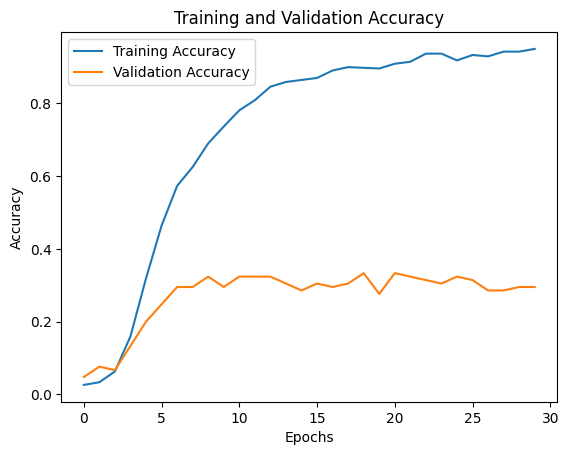

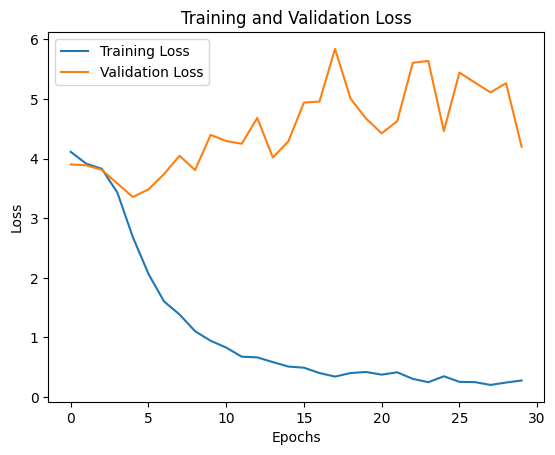

In [25]:

# Set paths and parameters
dataset_path = r'C:\Users\roshe\Documents\PROJECTS\Sign Language\Dataset\Hand_Detected'  # Path to the dataset folder
output_folder = 'model_metrics'  # Folder to save model and metrics
os.makedirs(output_folder, exist_ok=True)  # Create folder if it doesn't exist
img_size = (255, 255)
batch_size = 32
epochs = 30

# Define number of classes to train
num_classes_to_train = 50 # Adjust this variable to the desired number of classes

# Data augmentation and preprocessing
datagen = ImageDataGenerator(
    rescale=1.0 / 255,  # Normalize pixel values
    validation_split=0.2  # Split for validation
)

# Filter classes to only the specified number
all_classes = sorted(os.listdir(dataset_path))[:num_classes_to_train]

# Load training and validation data with specified classes
train_data = datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    classes=all_classes,  # Filter classes
    subset='training'
)

val_data = datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    classes=all_classes,  # Filter classes
    subset='validation'
)

# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(255, 255, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(num_classes_to_train, activation='softmax')  # Adjusted for chosen classes
])

# Compile the model
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Train the model with real-time feedback
history = model.fit(
    train_data,
    epochs=epochs,
    validation_data=val_data
)

# Save the model
model.save(os.path.join(output_folder, f'sign_language_cnn_model_{num_classes_to_train}_classes.h5'))

# Plot training & validation accuracy and loss
def plot_metrics(history, output_folder):
    # Accuracy plot
    plt.figure()
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig(os.path.join(output_folder, 'accuracy_plot.png'))
    
    # Loss plot
    plt.figure()
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(os.path.join(output_folder, 'loss_plot.png'))
    
plot_metrics(history, output_folder)

# Evaluate model on validation data to get metrics
val_data.reset()
predictions = model.predict(val_data, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = val_data.classes
class_labels = list(val_data.class_indices.keys())


# Save classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df.to_csv(os.path.join(output_folder, 'classification_report.csv'))

print(f"Training completed with {num_classes_to_train} classes. Model and metrics saved in the '{output_folder}' folder.")
